## Siemens: Funtional Data Analysis Pipeline

**Index**

1. Loading the datasets
2. Preprocessing steps
   - 2.1. Data wrangling on time series
   - 2.2. Data wrangling on additional features
   - 2.3. Merging time series datasets to add additional features
       - 2.3.1. Removal of testID only exists in one sensor
3. Window extraction
   - 3.1. Validating if there are partial or full missing values after the extraction
   - 3.2. Validating shape post-window extraction
   - 3.3. Scaling the post-window data: zero-alignment
   - 3.4. Merging scaled data with additional attributes of interest
   - 3.5. Balancing the specific attributes
   - 3.6. Windows visualization (balanced data)
4. FPCA characterization
   - 4.1. Functional PC1 plots (both systems): Characterization of FPC Scores
   - 4.2 Linear Regression for slope
5. Functional Regression
   - 5.1. Regression coefficients
   - 5.2. Coefficients visualization

In [1]:
#!pip install scikit-fda
import os
os.chdir("..")

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import random
import statsmodels.api as sm
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda.exploratory.visualization import FPCAPlot
from sklearn.preprocessing import OneHotEncoder
import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FDataBasis, FourierBasis
from skfda.exploratory.depth import IntegratedDepth, ModifiedBandDepth
from skfda.exploratory.visualization import Boxplot
# Import designed-functions
from window_extraction import calculate_window_values, calculate_window_data, Merge_data, align_to_zero, balance_index
from time_series_visualization import plot_all_time_series, plot_all_time_series_and_mean_fpca, plot_all_time_series_in_group
from functionalPCA import fpca_two_inputs, first_component_extraction, bootstrap, create_pc_scores_plots, visualize_regression
from functional_regression import Function_regression, coefficent_visualization

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14104\3302358765.py:9: DeprecationWarning: The module "projection" is deprecated. Please use "dim_reduction"
  from skfda.preprocessing.dim_reduction.projection import FPCA


# 1. Loading the datasets

The path of the files can be change based on where the data is stored.

In [3]:
# Import datasets
sensorA_System1 = pd.read_csv("RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("RawData/Key by TestID.csv", parse_dates=['DateTime'])

# 2. Preprocesing Steps

## 2.1. Data wrangling on time series

In [4]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [5]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

## 2.2. Data wrangling on additional features

In [6]:
# Relabeling System Values
keyByTestID["System"] = keyByTestID["System"].replace({"System 2A":"System 2","System 2B":"System 2"})

# Create new column to fill fluid temperature NA's
# Note: Fluid temperature: If specified, take as the temperature of the sample fluid. The rest of the system temperature can be taken as ambient temperature.
keyByTestID['Fluid_Temperature_Filled'] = keyByTestID['Fluid Temperature'].combine_first(keyByTestID['AmbientTemperature'])

# Binning 

# Categorize 'FluidType' into Blood and Aqueous
keyByTestID['FluidTypeBin'] = np.where(keyByTestID['FluidType'].str.startswith('Eurotrol'), 'Aqueous', 'Blood')

# Categorize 'AgeOfCardInDaysAtTimeOfTest' into bins
keyByTestID["CardAgeBin"] = pd.cut(keyByTestID["AgeOfCardInDaysAtTimeOfTest"], bins=[0, 9, 28, 56, 84, 112, 140, 168, 196, 224, 252],
                                   labels=['[0-9]', '(9-28]', '(28-56]', '(56-84]', '(84-112]', '(112-140]', '(140-168]', '(168-196]', '(196-224]', '(224-252]'])


# Categorize 'Fluid_Temperature_Filled' into bins
keyByTestID["FluidTempBin"] = pd.cut(keyByTestID["Fluid_Temperature_Filled"], bins=[-1, 20, 25, 100], labels=['Below 20', '20-25', 'Above 25'])

# Filtering successful tests
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

## 2.3. Merging time series datasets to add additional features

In [7]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 3380)
A2:  (7743, 3371)
B1:  (3375, 3380)
B2:  (7745, 3371)


### 2.3.1. Removal of testID only exists in one sensor

In [8]:
# Note: Only run once. If not, restart the kernel and run from the beggining again.
A1_Merged = A1_Merged[A1_Merged["TestID"].isin(B1_Merged["TestID"])]
B1_Merged = B1_Merged[B1_Merged["TestID"].isin(A1_Merged["TestID"])]

A2_Merged = A2_Merged[A2_Merged["TestID"].isin(B2_Merged["TestID"])]
B2_Merged = B2_Merged[B2_Merged["TestID"].isin(A2_Merged["TestID"])]
print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3374, 3380)
A2:  (7743, 3371)
B1:  (3374, 3380)
B2:  (7743, 3371)


# 3. Window extraction

In [9]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Sensor A
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end


# sensor B

# Match window values of Sensor B for each test
calDelimit = 20
cal_window_size = 18
sampleDelimit_blood = 24
sampleDelimit_aqueous = 30
sample_window_size = 4

B1_Merged['cal_window_start'], B1_Merged['cal_window_end'], \
B1_Merged['sample_window_start'], B1_Merged['sample_window_end'] = zip(*B1_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit_input=calDelimit,
        cal_window_size_input=cal_window_size,
        sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size_input=sample_window_size
    ),
    axis=1
))

# For sensor B in system 2, blood and aqueous
B2_Merged['cal_window_start'], B2_Merged['cal_window_end'], \
B2_Merged['sample_window_start'], B2_Merged['sample_window_end'] = zip(*B2_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit_input=calDelimit,
        cal_window_size_input=cal_window_size,
        sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size_input=sample_window_size
    ),
    axis=1
))


In [10]:
# Adds TestIDs as index to the values post-window extraction 
# System 1 - Sensor A

A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID'].astype(int)
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID'].astype(int)
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B

B1_cal_window = []
B1_sample_window = []
for i in range(len(B1_Merged)):
    cal_window, sample_window = calculate_window_data(B1_Merged.iloc[i, :])
    B1_cal_window.append(cal_window.values)
    B1_sample_window.append(sample_window.values)
B1_cal_window = pd.DataFrame(B1_cal_window)
B1_sample_window = pd.DataFrame(B1_sample_window)
B1_cal_window['TestID'] = B1_sample_window['TestID'] = B1_Merged['TestID'].astype(int)
B1_sample_window.set_index('TestID',inplace=True)
B1_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor B

B2_cal_window = []
B2_sample_window = []
for i in range(len(B2_Merged)):
    cal_window, sample_window = calculate_window_data(B2_Merged.iloc[i, :])
    B2_cal_window.append(cal_window.values)
    B2_sample_window.append(sample_window.values)
B2_cal_window = pd.DataFrame(B2_cal_window)
B2_sample_window = pd.DataFrame(B2_sample_window)
B2_cal_window['TestID'] = B2_sample_window['TestID'] = B2_Merged['TestID'].astype(int)
B2_sample_window.set_index('TestID',inplace=True)
B2_cal_window.set_index('TestID',inplace=True)

## 3.1. Validating if there are partial or full missing values after the extraction

In [11]:
A1_cal_window_drop_index = A1_cal_window.loc[A1_cal_window.isna().sum(axis=1)!=0].index
A2_cal_window_drop_index = A2_cal_window.loc[A2_cal_window.isna().sum(axis=1)!=0].index

A1_sample_window_drop_index = A1_sample_window.loc[A1_sample_window.isna().sum(axis=1)!=0].index
A2_sample_window_drop_index = A2_sample_window.loc[A2_sample_window.isna().sum(axis=1)!=0].index

B1_cal_window_drop_index = B1_cal_window.loc[B1_cal_window.isna().sum(axis=1)!=0].index
B2_cal_window_drop_index = B2_cal_window.loc[B2_cal_window.isna().sum(axis=1)!=0].index

B1_sample_window_drop_index = B1_sample_window.loc[B1_sample_window.isna().sum(axis=1)!=0].index
B2_sample_window_drop_index = B2_sample_window.loc[B2_sample_window.isna().sum(axis=1)!=0].index

# Check if missing values in different windows is different
print("The missing value in calibration window:",A1_cal_window_drop_index)
print("The missing value in sample window:",A1_sample_window_drop_index)
print("The missing value in calibration window:",A2_cal_window_drop_index)
print("The missing value in sample window:",A2_sample_window_drop_index)

print("The missing value in calibration window:",B1_cal_window_drop_index)
print("The missing value in sample window:",B1_sample_window_drop_index)
print("The missing value in calibration window:",B2_cal_window_drop_index)
print("The missing value in sample window:",B2_sample_window_drop_index)

The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')
The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')
The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')


## 3.2. Validating data shape post-window extraction

In [12]:
# Set index for Merge datasets
A1_Merged.set_index("TestID", inplace=True)
A2_Merged.set_index("TestID", inplace=True)
B1_Merged.set_index("TestID", inplace=True)
B2_Merged.set_index("TestID", inplace=True)

# Find missing value
print("The problem indexes after extract the window are:",A1_Merged.index.difference(A1_cal_window.index))
print("The problem indexes after extract the window are:",A1_Merged.index.difference(A1_sample_window.index))
print("The problem indexes after extract the window are:",A2_Merged.index.difference(A2_cal_window.index))
print("The problem indexes after extract the window are:",A2_Merged.index.difference(A2_sample_window.index))

print("The problem indexes after extract the window are:",B1_Merged.index.difference(B1_cal_window.index))
print("The problem indexes after extract the window are:",B1_Merged.index.difference(B1_sample_window.index))
print("The problem indexes after extract the window are:",B2_Merged.index.difference(B2_cal_window.index))
print("The problem indexes after extract the window are:",B2_Merged.index.difference(B2_sample_window.index))

A1_Merged = A1_Merged.drop(A1_Merged.index.difference(A1_cal_window.index))
A1_Merged = A1_Merged.drop(A1_Merged.index.difference(A1_sample_window.index))
A2_Merged = A2_Merged.drop(A2_Merged.index.difference(A2_cal_window.index))
A2_Merged = A2_Merged.drop(A2_Merged.index.difference(A2_sample_window.index))

B1_Merged = B1_Merged.drop(B1_Merged.index.difference(B1_cal_window.index))
B1_Merged = B1_Merged.drop(B1_Merged.index.difference(B1_sample_window.index))
B2_Merged = B2_Merged.drop(B2_Merged.index.difference(B2_cal_window.index))
B2_Merged = B2_Merged.drop(B2_Merged.index.difference(B2_sample_window.index))

# Clear the Nan in index of sensor A
A1_cal_window = A1_cal_window[~A1_cal_window.index.isna()]
A1_sample_window = A1_sample_window[~A1_sample_window.index.isna()]
A2_cal_window = A2_cal_window[~A2_cal_window.index.isna()]
A2_sample_window = A2_sample_window[~A2_sample_window.index.isna()]

# Clear the Nan in index of sensor B
B1_cal_window = B1_cal_window[~B1_cal_window.index.isna()]
B1_sample_window = B1_sample_window[~B1_sample_window.index.isna()]
B2_cal_window = B2_cal_window[~B2_cal_window.index.isna()]
B2_sample_window = B2_sample_window[~B2_sample_window.index.isna()]


The problem indexes after extract the window are: Int64Index([12470355, 12470361, 12470365, 12537663, 12539049, 12622570], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([12470355, 12470361, 12470365, 12537663, 12539049, 12622570], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([12622570], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([12622570], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([3518677, 3518678], dtype='int64', name='TestID')
The problem indexes after extract the window are: Int64Index([3518677, 3518678], dtype='int64', name='TestID')


In [13]:
# Shape of the subsets of time series after the extraction from the windows

# Cal Window
print('Shape of the time series after extraction')
print('A1_cal_window: ', A1_cal_window.shape)
print('A2_cal_window: ', A2_cal_window.shape)
print('B1_cal_window: ', B1_cal_window.shape)
print('B2_cal_window: ', B2_cal_window.shape)

# Sample Window
print('A1_sample_window: ', A1_sample_window.shape)
print('A2_sample_window: ', A2_sample_window.shape)
print('B1_sample_window: ', B1_sample_window.shape)
print('B2_sample_window: ', B2_sample_window.shape)

# We can delete the unmatch index but it is not necessary

Shape of the time series after extraction
A1_cal_window:  (3368, 41)
A2_cal_window:  (7743, 41)
B1_cal_window:  (3373, 91)
B2_cal_window:  (7741, 91)
A1_sample_window:  (3368, 26)
A2_sample_window:  (7743, 26)
B1_sample_window:  (3373, 21)
B2_sample_window:  (7741, 21)


## 3.3. Scaling the post-window data: zero-alignment

In [14]:
# Cal Window

A1_cal_window_zero = align_to_zero(A1_cal_window)
A2_cal_window_zero = align_to_zero(A2_cal_window)
B1_cal_window_zero = align_to_zero(B1_cal_window)
B2_cal_window_zero = align_to_zero(B2_cal_window)


# Sample Window

A1_sample_window_zero = align_to_zero(A1_sample_window)
A2_sample_window_zero = align_to_zero(A2_sample_window)
B1_sample_window_zero = align_to_zero(B1_sample_window)
B2_sample_window_zero = align_to_zero(B2_sample_window)


## 3.4. Merging scaled data with additional attributes of interest

In [15]:
# Combine data: Merge the zero-aligned time series with "FluidType", "AgeOfCardInDaysAtTimeOfTest", "Fluid_Temperature_Filled", "FluidTypeBin", "CardAgeBin", "FluidTempBin"
A1_cal_window_combine = Merge_data(A1_cal_window_zero,A1_Merged)
A2_cal_window_combine = Merge_data(A2_cal_window_zero,A2_Merged)

B1_cal_window_combine = Merge_data(B1_cal_window_zero,B1_Merged)
B2_cal_window_combine = Merge_data(B2_cal_window_zero,B2_Merged)

## Sample window
A1_sample_window_combine = Merge_data(A1_sample_window_zero,A1_Merged)
A2_sample_window_combine = Merge_data(A2_sample_window_zero,A2_Merged)

B1_sample_window_combine = Merge_data(B1_sample_window_zero,B1_Merged)
B2_sample_window_combine = Merge_data(B2_sample_window_zero,B2_Merged)

## 3.5. Balancing the specific attributes

In [16]:
System1_Index, System2_Index =  balance_index(A1_cal_window_combine,A2_cal_window_combine,"FluidType")

System1 Sensor A & B distribution:
 AB             30
DB             30
Eurotrol L1    30
Eurotrol L3    30
Eurotrol L4    30
Eurotrol L5    30
HNB            30
NB             30
SB             30
SB-3           30
TB11           30
Name: FluidType, dtype: int64

 System2 Sensor A & B distribution:
 AB             30
DB             30
Eurotrol L1    30
Eurotrol L3    30
Eurotrol L4    30
Eurotrol L5    30
HNB            30
NB             30
SB             30
SB-3           30
TB11           30
Name: FluidType, dtype: int64


In [17]:
# Balanced data
A1_cal_window_combine_balanced = A1_cal_window_combine.loc[System1_Index]
A1_sample_window_combine_balanced = A1_sample_window_combine.loc[System1_Index]
A2_cal_window_combine_balanced = A2_cal_window_combine.loc[System2_Index]
A2_sample_window_combine_balanced = A2_sample_window_combine.loc[System2_Index]

B1_cal_window_combine_balanced = B1_cal_window_combine.loc[System1_Index]
B1_sample_window_combine_balanced = B1_sample_window_combine.loc[System1_Index]
B2_cal_window_combine_balanced = B2_cal_window_combine.loc[System2_Index]
B2_sample_window_combine_balanced = B2_sample_window_combine.loc[System2_Index]

## 3.6. Windows visualization

### Fluid Temperature

#### System 1 and System 2: Sensor A - Cal and Sample Windows

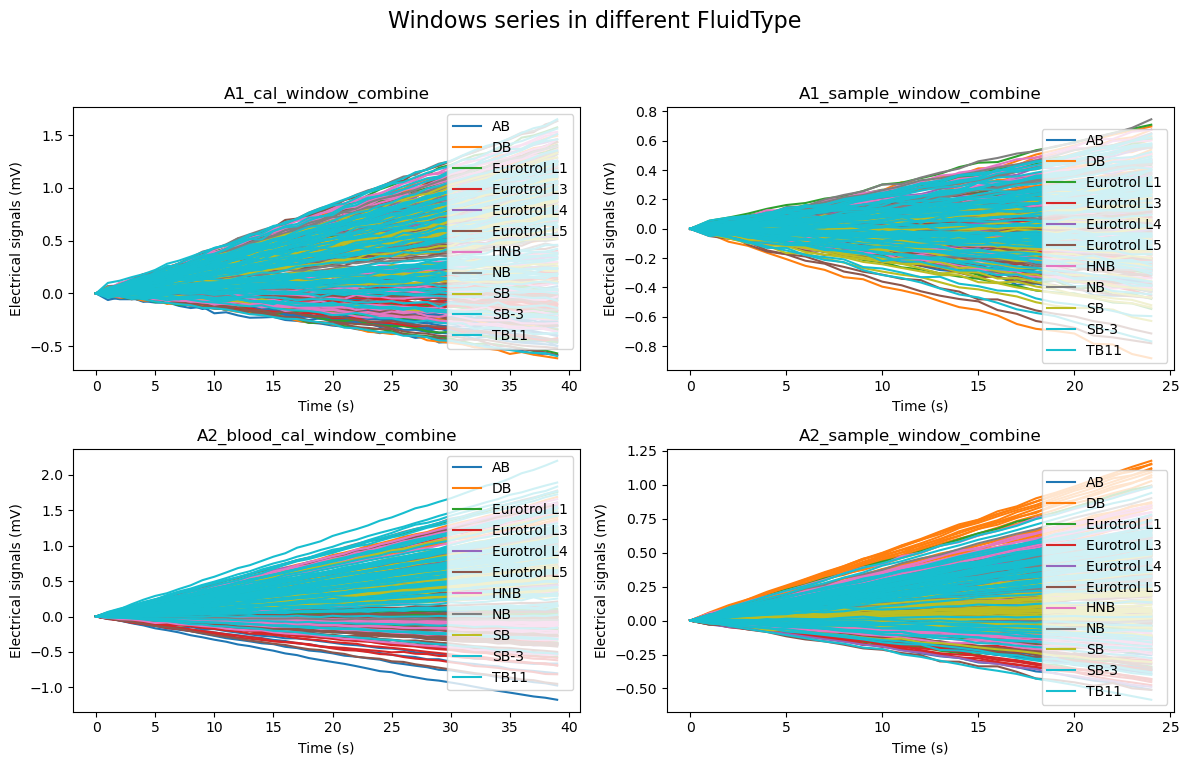

In [18]:
# Plot all the balanced time series from the window extraction
plot_all_time_series_in_group(A1_cal_window_combine_balanced, A1_sample_window_combine_balanced, A2_cal_window_combine_balanced, A2_sample_window_combine_balanced, "FluidType", "A1_cal_window_combine", "A1_sample_window_combine","A2_blood_cal_window_combine", "A2_sample_window_combine")

#### System 1 and System 2: Sensor B - Cal and Sample Windows

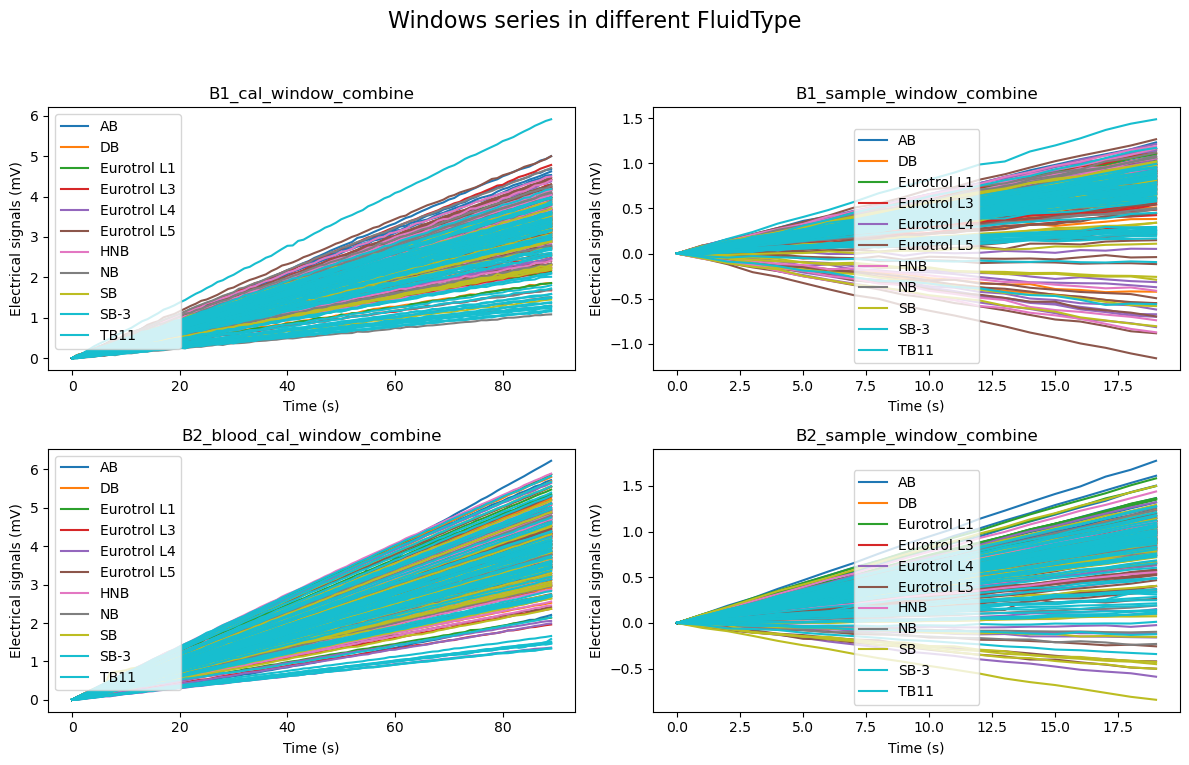

In [19]:
# Plot all the balanced time series from the window extraction
plot_all_time_series_in_group(B1_cal_window_combine_balanced, B1_sample_window_combine_balanced, B2_cal_window_combine_balanced, B2_sample_window_combine_balanced, "FluidType", "B1_cal_window_combine", "B1_sample_window_combine", "B2_blood_cal_window_combine", "B2_sample_window_combine")


# 4. FPCA characterization

## 4.1. Functional PC1 plots (both systems) and Characterization of FPC Scores

The following secssion will introduce 
1. Explan variance
2. Waveforms with significant features of different components
3. Plot 1-2: all the waveforms and one mean waveform after aggregating
4. Plot 3-4: The first two component in different systems
5. Plot 5: The first component of two systems in the same canvas
6. Plot 6: The confidential interval of two systems by bootstrap
7. Plot 7-8: The boxplots in two systems show the different percentile about the first component
    - Red dashed lines indicate detected outliers
    - Red area shows the box region
8. Plot 9-12: The visualization of PCA component scores

### System 1 versus System 2: Sensor A - Cal Window

S1 Explain variance PC1 (%):  99.87465064602365
S1 Explain variance PC2 (%):  0.03624447782240029
S2 Explain variance PC1 (%):  99.95205967497282
S2 Explain variance PC2 (%):  0.01858548207481919
The time series contributing most to PC1 is at index 42 with TestID 12480741.0
The time series contributing most to PC2 is at index 153 with TestID 12602248.0
The time series contributing most to PC1 is at index 14 with TestID 3568561
The time series contributing most to PC2 is at index 115 with TestID 3562108


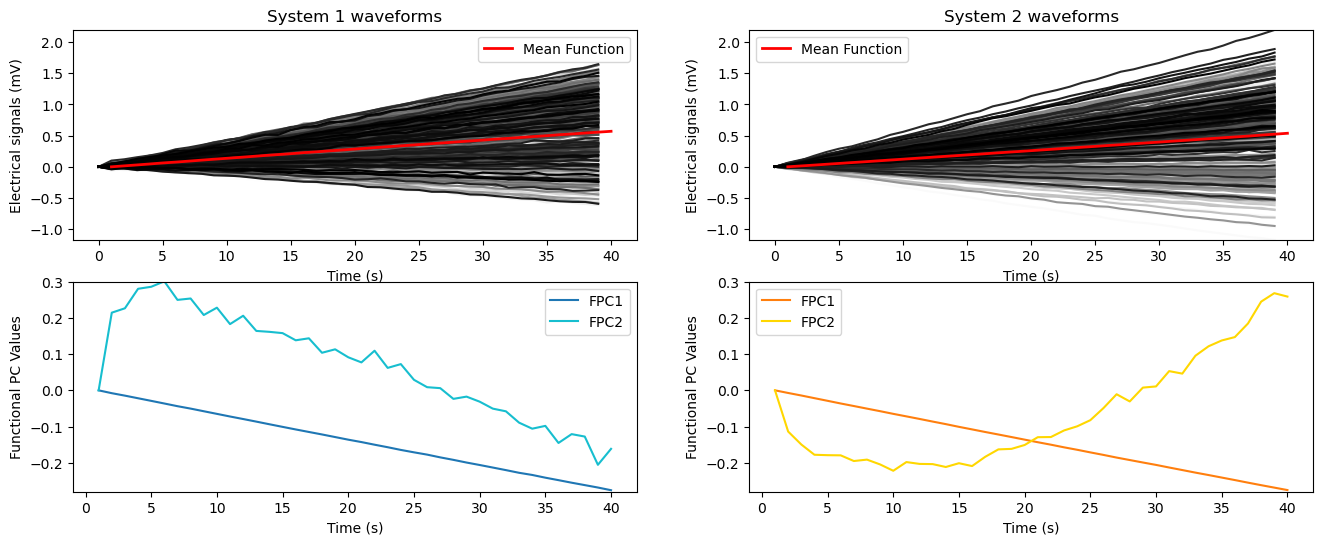

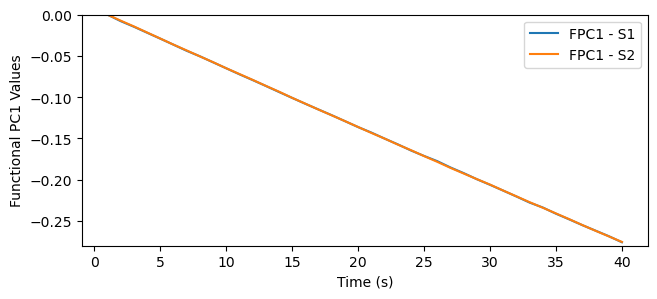

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 30
The boxplot of 1st Component


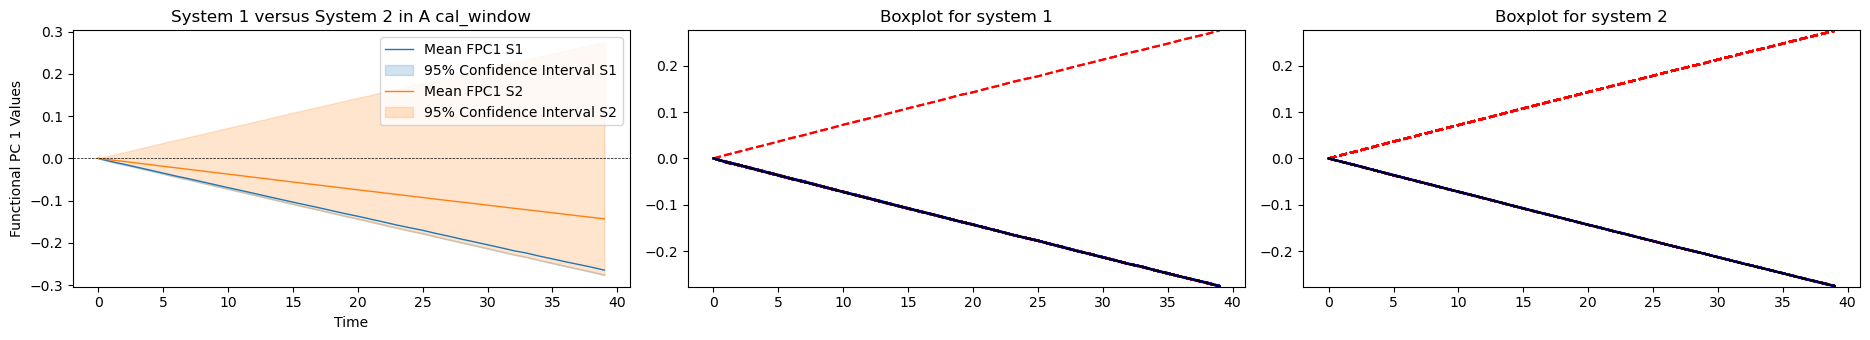

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [20]:
pc_scores_s1_A_cal_window, pc_scores_s2_A_cal_window,fpca_s1_A_cal_window,fpca_s2_A_cal_window = fpca_two_inputs(A1_cal_window_combine_balanced.iloc[:,:-6], A2_cal_window_combine_balanced.iloc[:,:-6], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
ac1, ac2 = bootstrap(A1_cal_window_combine_balanced, A2_cal_window_combine_balanced,"A","cal_window",features="FluidType")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_A_cal_window, pc_scores_s2_A_cal_window, A1_cal_window_combine_balanced, A2_cal_window_combine_balanced,features="FluidType")

### System 1 versus System 2: Sensor A - Sample Window

S1 Explain variance PC1 (%):  99.59916405464509
S1 Explain variance PC2 (%):  0.12130251714250896
S2 Explain variance PC1 (%):  99.8953686384524
S2 Explain variance PC2 (%):  0.03727989884890443
The time series contributing most to PC1 is at index 42 with TestID 12480741.0
The time series contributing most to PC2 is at index 97 with TestID 12372583.0
The time series contributing most to PC1 is at index 41 with TestID 3569372
The time series contributing most to PC2 is at index 95 with TestID 3561376


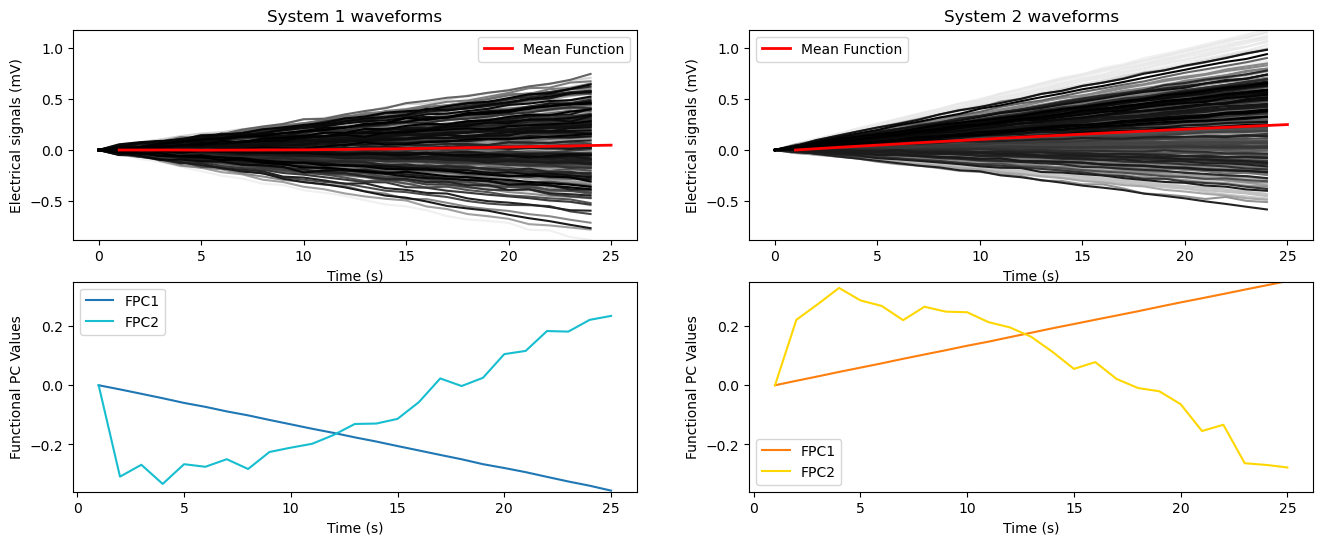

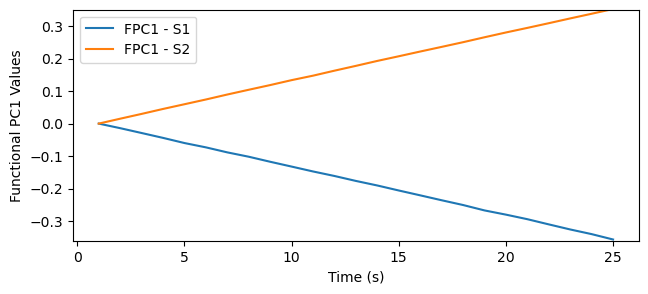

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 30
The boxplot of 1st Component


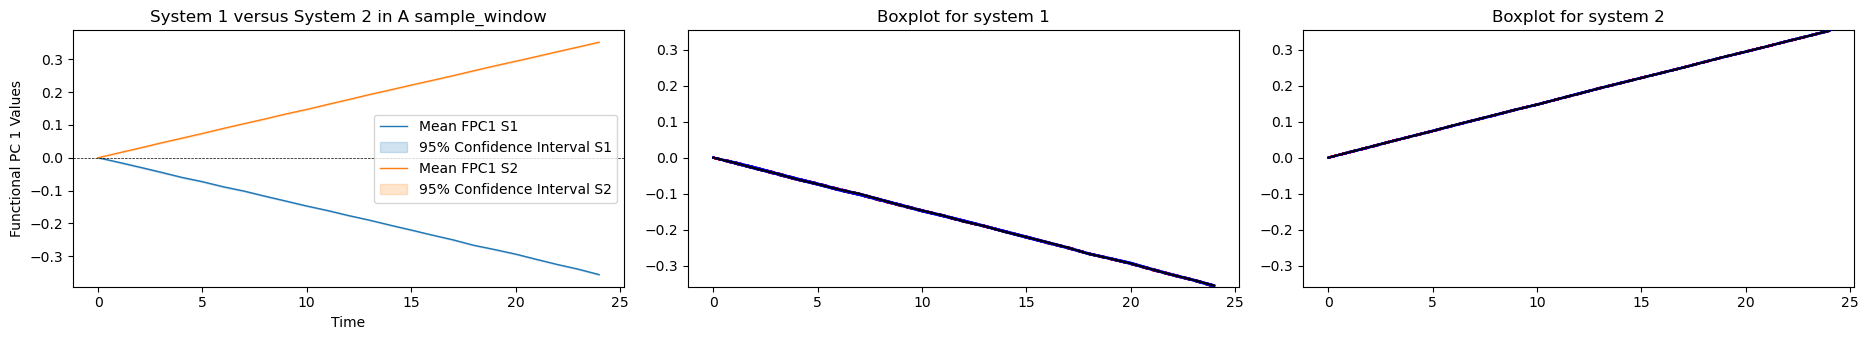

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [21]:
pc_scores_s1_A_sample_window, pc_scores_s2_A_sample_window,fpca_s1_A_sample_window,fpca_s2_A_sample_window = fpca_two_inputs(A1_sample_window_combine_balanced.iloc[:,:-6], A2_sample_window_combine_balanced.iloc[:,:-6], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
as1,as2 = bootstrap(A1_sample_window_combine_balanced, A2_sample_window_combine_balanced,"A","sample_window",features="FluidType")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_A_sample_window, pc_scores_s2_A_sample_window, A1_sample_window_combine_balanced, A2_sample_window_combine_balanced,features="FluidType")

### System 1 versus System 2: Sensor B - Cal Window

S1 Explain variance PC1 (%):  99.85104619597266
S1 Explain variance PC2 (%):  0.09179236410628389
S2 Explain variance PC1 (%):  99.83993193651227
S2 Explain variance PC2 (%):  0.12107735450276923
The time series contributing most to PC1 is at index 322 with TestID 12390103.0
The time series contributing most to PC2 is at index 3 with TestID 12432835.0
The time series contributing most to PC1 is at index 273 with TestID 3518627.0
The time series contributing most to PC2 is at index 93 with TestID 3545444.0


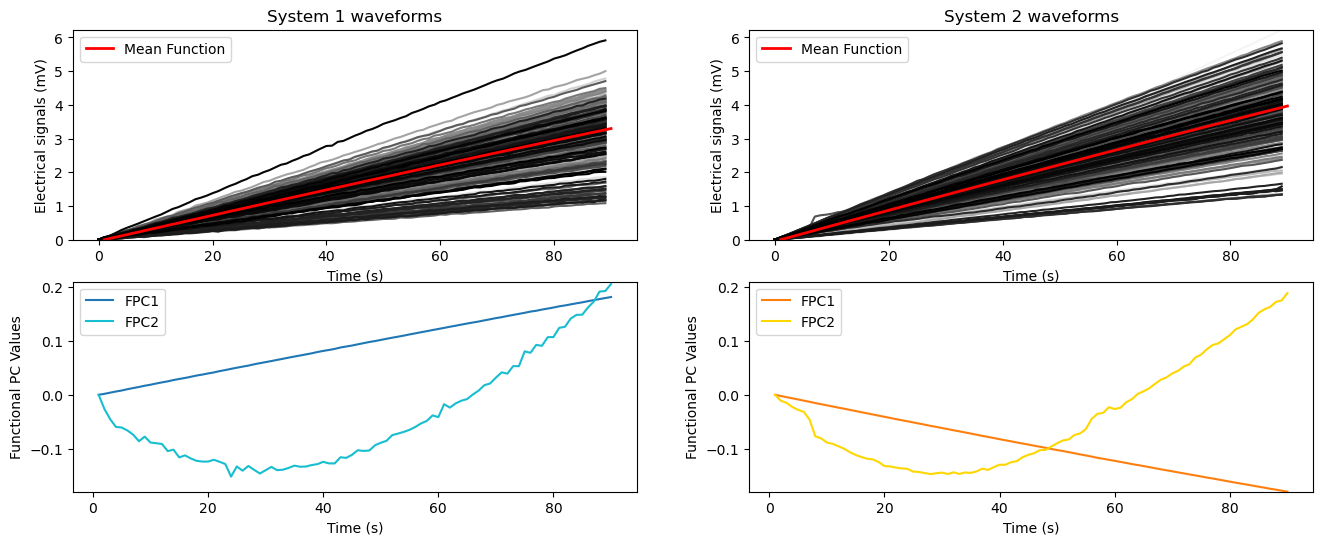

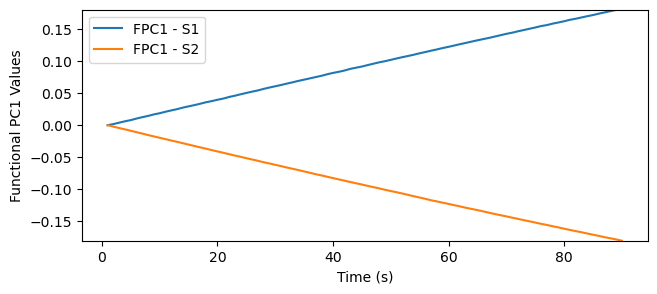

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 30
The boxplot of 1st Component


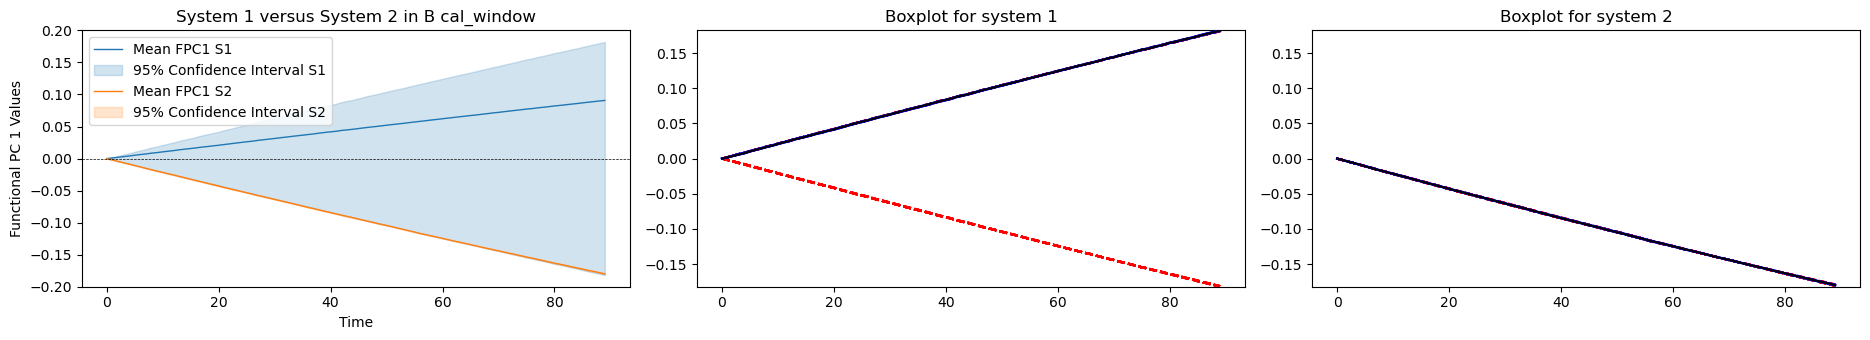

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [22]:
pc_scores_s1_B_cal_window, pc_scores_s2_B_cal_window,fpca_s1_B_cal_window,fpca_s2_B_cal_window = fpca_two_inputs(B1_cal_window_combine_balanced.iloc[:,:-6], B2_cal_window_combine_balanced.iloc[:,:-6], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
bc1,bc2 = bootstrap(B1_cal_window_combine_balanced, B2_cal_window_combine_balanced,"B","cal_window",features="FluidType")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_B_cal_window, pc_scores_s2_B_cal_window, B1_cal_window_combine_balanced, B2_cal_window_combine_balanced,features="FluidType")

### System 1 versus System 2: Sensor B - Sample Window

S1 Explain variance PC1 (%):  99.79086552731343
S1 Explain variance PC2 (%):  0.05959603480573876
S2 Explain variance PC1 (%):  99.87949421069499
S2 Explain variance PC2 (%):  0.0628569264815463
The time series contributing most to PC1 is at index 179 with TestID 12191206.0
The time series contributing most to PC2 is at index 153 with TestID 12602248.0
The time series contributing most to PC1 is at index 262 with TestID 3563527.0
The time series contributing most to PC2 is at index 235 with TestID 3563443.0


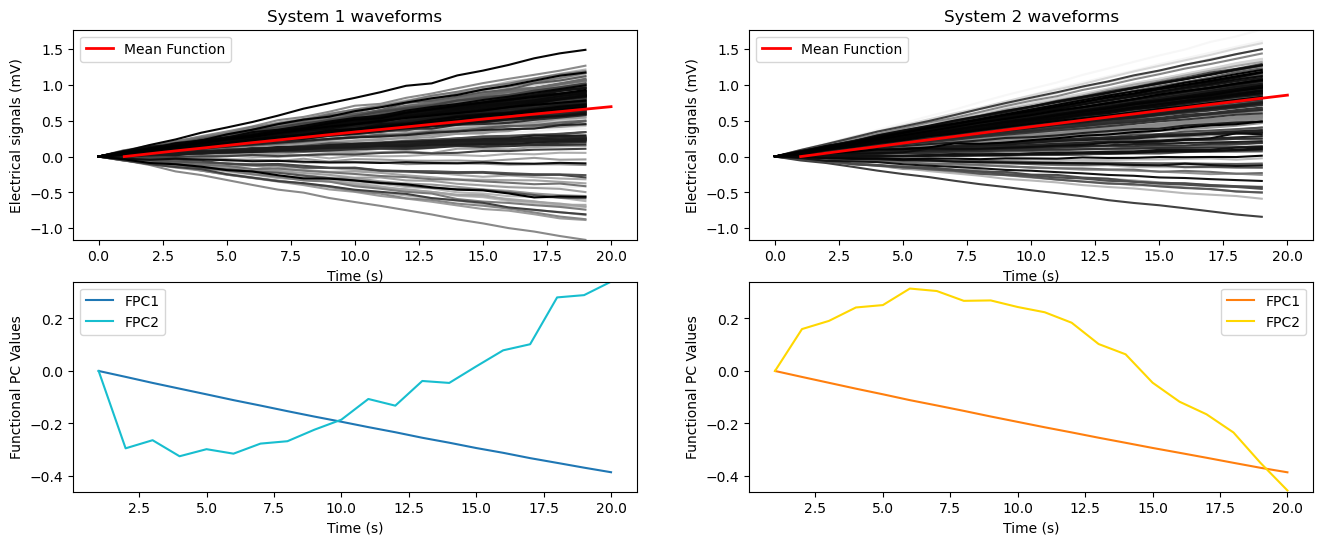

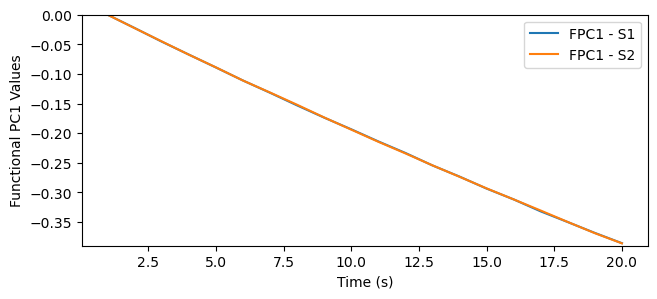

--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------
Confidence Interval of 1st component
The number of sampling is 30
The boxplot of 1st Component


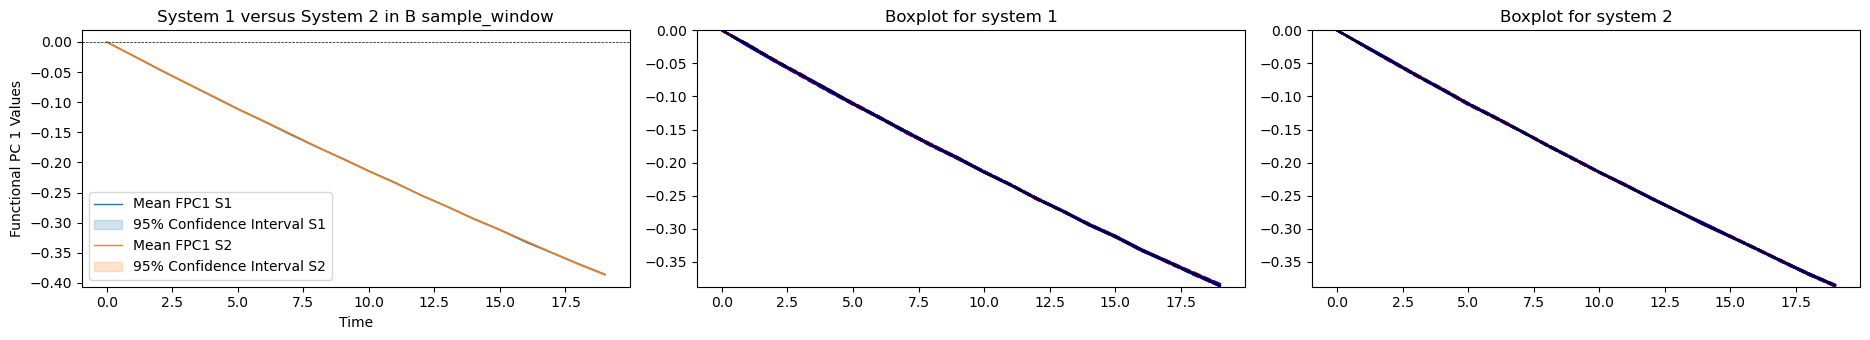

--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------


alt.VConcatChart(...)

In [23]:
pc_scores_s1_B_sample_window, pc_scores_s2_B_sample_window,fpca_s1_B_sample_window,fpca_s2_B_sample_window = fpca_two_inputs(B1_sample_window_combine_balanced.iloc[:,:-6], B2_sample_window_combine_balanced.iloc[:,:-6], color_fpc1_s1='tab:blue', color_fpc2_s1='tab:cyan', color_fpc1_s2='tab:orange', color_fpc2_s2='gold')
print("--------------------------------------------------- Bootstrap -------------------------------------------------------------------------------------------")
bs1,bs2 = bootstrap(B1_sample_window_combine_balanced, B2_sample_window_combine_balanced, "B","sample_window",features="FluidType")
print("--------------------------------------------------- PCA Scores -------------------------------------------------------------------------------------------")
create_pc_scores_plots(pc_scores_s1_B_sample_window, pc_scores_s2_B_sample_window, B1_sample_window_combine_balanced, B2_sample_window_combine_balanced,features="FluidType")

## 4.2 Linear Regression for slope

### R-square and visualization

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.034e+05
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           8.54e-84
Time:                        21:08:06   Log-Likelihood:                 242.71
No. Observations:                  40   AIC:                            -481.4
Df Residuals:                      38   BIC:                            -478.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0.000     30.780      0.0

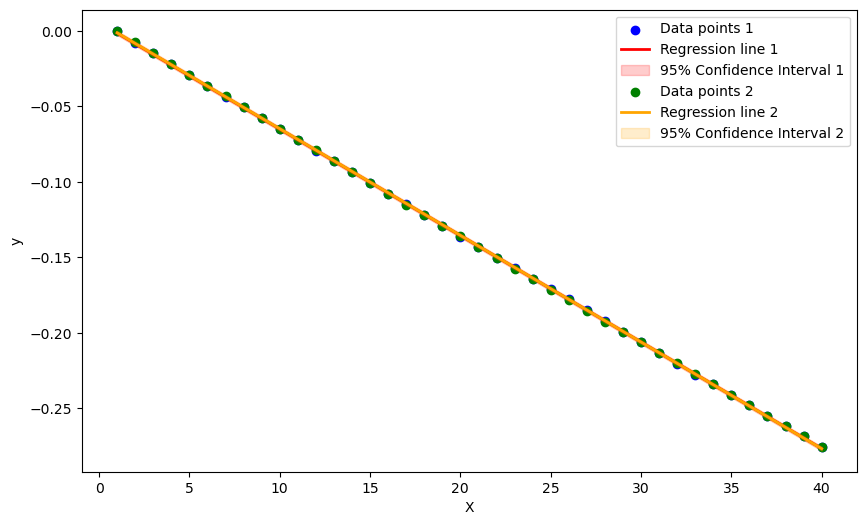

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.117e+05
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           2.04e-50
Time:                        21:08:06   Log-Likelihood:                 142.88
No. Observations:                  25   AIC:                            -281.8
Df Residuals:                      23   BIC:                            -279.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0156      0.000     45.516      0.0

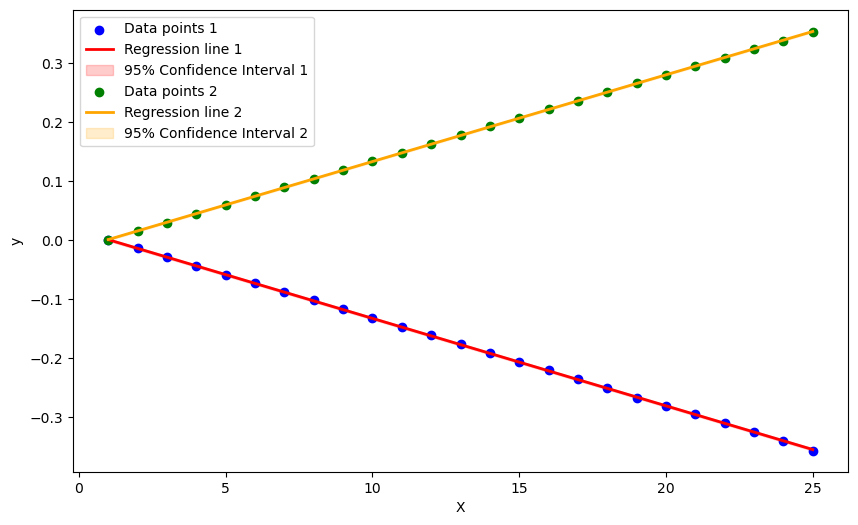

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.424e+05
Date:                Wed, 12 Jun 2024   Prob (F-statistic):          8.70e-172
Time:                        21:08:06   Log-Likelihood:                 536.67
No. Observations:                  90   AIC:                            -1069.
Df Residuals:                      88   BIC:                            -1064.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.000     -8.393      0.0

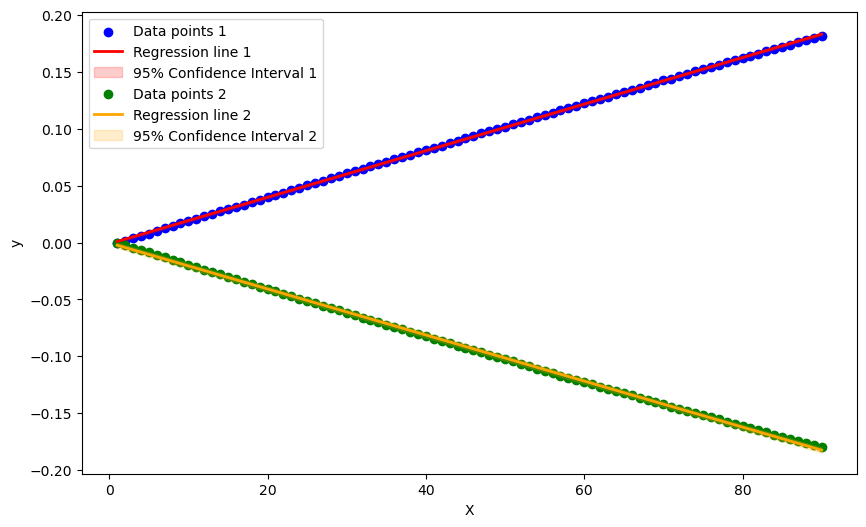

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.909e+04
Date:                Wed, 12 Jun 2024   Prob (F-statistic):           1.08e-28
Time:                        21:08:07   Log-Likelihood:                 84.183
No. Observations:                  20   AIC:                            -164.4
Df Residuals:                      18   BIC:                            -162.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0130      0.002      7.406      0.0

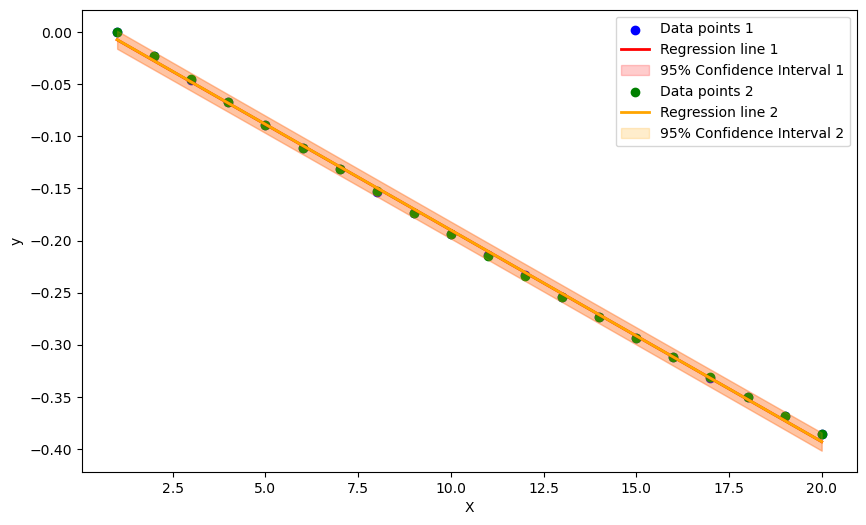

In [24]:
df_list = []

def append_to_dataframe(window_name, slope1, slope2):
    global df_list
    df_list.append({'Window': window_name, 'Slope 1': slope1, 'Slope 2': slope2})
append_to_dataframe('A_cal_window', *visualize_regression(fpca_s1_A_cal_window, fpca_s2_A_cal_window))
append_to_dataframe('A_sample_window', *visualize_regression(fpca_s1_A_sample_window, fpca_s2_A_sample_window))
append_to_dataframe('B_cal_window', *visualize_regression(fpca_s1_B_cal_window, fpca_s2_B_cal_window))
append_to_dataframe('B_sample_window', *visualize_regression(fpca_s1_B_sample_window, fpca_s2_B_sample_window))

### Slopes Results Comparison for one sample

In [25]:
slopes_df = pd.DataFrame(df_list)
slopes_df

,Window,Slope 1,Slope 2
0,A_cal_window,-0.007059,-0.007066
1,A_sample_window,-0.014793,0.014669
2,B_cal_window,0.002047,-0.002023
3,B_sample_window,-0.020308,-0.020310


# 5. Functional Regression

This is another functional analysis method. Unlike FPCA, the following analysis utilizes **the entire time series** in a balanced and centered dataset as  response variables for regression with **the features before grouping by bins**. This is done to distinguish between two systems under the influence of features.

## 5.1. Regression coefficients

This is the coeffcient from the output of the model.
Because of the different magnitude, we need to choose the time stamps before we visualize

### Sensor A

#### Cal window

In [26]:
print("System 1:")
A1_cal_window_funct_reg = Function_regression(A1_cal_window_combine_balanced,40,['FluidType'])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_cal_window_funct_reg = Function_regression(A2_cal_window_combine_balanced,40,['FluidType'])

System 1:
Not appliable
----------------------------------------------------------------------------

 System 2:
Not appliable


#### Sample window

In [27]:
print("System 1:")
A1_sample_window_funct_reg = Function_regression(A1_sample_window_combine_balanced,25,["FluidType"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
A2_sample_window_funct_reg = Function_regression(A2_sample_window_combine_balanced,25,["FluidType"])


System 1:
Not appliable
----------------------------------------------------------------------------

 System 2:
Not appliable


### Sensor B

#### Cal window

In [28]:
print("System 1:")
B1_cal_window_funct_reg = Function_regression(B1_cal_window_combine_balanced,90,["FluidType"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_cal_window_funct_reg = Function_regression(B2_cal_window_combine_balanced,90,["FluidType"])

System 1:
Not appliable
----------------------------------------------------------------------------

 System 2:
Not appliable


#### Sample window

In [29]:
print("System 1:")
B1_sample_window_funct_reg = Function_regression(B1_sample_window_combine_balanced,20,["FluidType"])
print("----------------------------------------------------------------------------")
print("\n","System 2:")
B2_sample_window_funct_reg = Function_regression(B2_sample_window_combine_balanced,20,["FluidType"])

System 1:
Not appliable
----------------------------------------------------------------------------

 System 2:
Not appliable


## 5.2. Coefficients visualization


As the result show above, the first time point is larger than others. And apart from **Sample Window Sensor A** (the last two points), the value at the last 4 time stamps are also significantly greater than the rest of the data. 
* Same case in both systems.
* Same case in both sensors.

So for the convenience of visualization, we remove these points.

### Sensor A

#### Cal window

In [30]:
coefficent_visualization(A1_cal_window_funct_reg,A2_cal_window_funct_reg,["FluidType"],range(1,36),"SensorA Cal window")

Not Appliable


#### Sample window

In [31]:
coefficent_visualization(A1_sample_window_funct_reg,A2_sample_window_funct_reg,["FluidType"],range(1,23),"SensorA sample window")

Not Appliable


### Sensor B

#### Cal window

In [32]:
coefficent_visualization(B1_cal_window_funct_reg,B2_cal_window_funct_reg,["FluidType"],range(1,86),"SensorB Cal window")

Not Appliable


#### Sample window

In [33]:
coefficent_visualization(B1_sample_window_funct_reg, B2_sample_window_funct_reg, ["FluidType"], range(1, 16), "SensorB Sample window")

Not Appliable
